In [2]:
from pymongo import MongoClient

In [3]:
import pandas as pd

In [4]:
from sklearn.preprocessing import OneHotEncoder, LabelEncoder

In [5]:
import xgboost as xgb

In [6]:
from sklearn.metrics import accuracy_score, log_loss

In [25]:
from sklearn.model_selection import train_test_split, GridSearchCV

In [26]:
import matplotlib.pyplot as plt

In [ ]:
# Connect to MongoDB
client = MongoClient("mongodb+srv://admin:<mypassword>@cluster0.jwzyj.mongodb.net/?retryWrites=true&w=majority&appName=Cluster0") 
db = client["hotel_guests"]
collection = db["dining_info"]

In [28]:
# Load data into a DataFrame
df_from_mongo = pd.DataFrame(list(collection.find()))
df = df_from_mongo.copy()

In [29]:
# Convert date columns to datetime format
df['check_in_date'] = pd.to_datetime(df['check_in_date'])
df['check_out_date'] = pd.to_datetime(df['check_out_date'])
df['order_time'] = pd.to_datetime(df['order_time'])

In [30]:
# Extract date-related features
df['check_in_day'] = df['check_in_date'].dt.dayofweek  # Monday=0, Sunday=6
df['check_out_day'] = df['check_out_date'].dt.dayofweek
df['check_in_month'] = df['check_in_date'].dt.month
df['check_out_month'] = df['check_out_date'].dt.month
df['stay_duration'] = (df['check_out_date'] - df['check_in_date']).dt.days

In [31]:
# Split dataset into historical, training, and test sets
features_df = df[df['order_time'] < '2024-01-01']
train_df = df[(df['order_time'] >= '2024-01-01') & (df['order_time'] <= '2024-10-01')]
test_df = df[df['order_time'] > '2024-10-01']

In [32]:
# Customer-level features
customer_features = features_df.groupby('customer_id').agg(
    total_orders_per_customer=('transaction_id', 'count'),
    avg_spend_per_customer=('price_for_1', 'mean')
).reset_index()

In [33]:
# Most frequent dish per customer
customer_dish = features_df.groupby('customer_id')['dish'].agg(lambda x: x.mode()[0]).reset_index()

In [34]:
# Cuisine-level aggregations
cuisine_features = features_df.groupby('Preferred Cusine').agg(
    total_orders_per_cuisine=('transaction_id', 'count')
).reset_index()

In [35]:
# Most popular dish per cuisine
cuisine_popular_dish = features_df.groupby('Preferred Cusine')['dish'].agg(lambda x: x.mode()[0]).reset_index()
cuisine_popular_dish = cuisine_popular_dish.rename(columns={'dish': 'popular_dish_for_this_cuisine'})


In [36]:
# Merge features into train_df
train_df = train_df.merge(customer_features, on='customer_id', how='left')
train_df = train_df.merge(customer_dish.rename(columns={'dish': 'fav_dish_per_customer'}), on='customer_id', how='left')
train_df = train_df.merge(cuisine_features, on='Preferred Cusine', how='left')
train_df = train_df.merge(cuisine_popular_dish, on='Preferred Cusine', how='left')

In [37]:
# Drop unnecessary columns
train_df.drop(['_id', 'transaction_id', 'customer_id', 'price_for_1', 'Qty', 'order_time', 'check_in_date', 'check_out_date'], axis=1, inplace=True)

In [38]:
# One-Hot Encoding for categorical features
categorical_cols = ['Preferred Cusine', 'fav_dish_per_customer', 'popular_dish_for_this_cuisine']
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')

encoded_array = encoder.fit_transform(train_df[categorical_cols])
encoded_df = pd.DataFrame(encoded_array, columns=encoder.get_feature_names_out(categorical_cols))

In [39]:
# Concatenate with train_df
train_df = pd.concat([train_df.drop(columns=categorical_cols), encoded_df], axis=1)

In [40]:
# Process test dataset
test_df = test_df.merge(customer_features, on='customer_id', how='left')
test_df = test_df.merge(customer_dish.rename(columns={'dish': 'fav_dish_per_customer'}), on='customer_id', how='left')
test_df = test_df.merge(cuisine_features, on='Preferred Cusine', how='left')
test_df = test_df.merge(cuisine_popular_dish, on='Preferred Cusine', how='left')

test_df.drop(['_id', 'transaction_id', 'customer_id', 'price_for_1', 'Qty', 'order_time', 'check_in_date', 'check_out_date'], axis=1, inplace=True)

encoded_test = encoder.transform(test_df[categorical_cols])
encoded_test_df = pd.DataFrame(encoded_test, columns=encoder.get_feature_names_out(categorical_cols))

test_df = pd.concat([test_df.drop(columns=categorical_cols), encoded_test_df], axis=1)

In [41]:
# Encode the target variable
train_df = train_df.dropna(subset=['dish'])
label_encoder = LabelEncoder()
train_df['dish'] = label_encoder.fit_transform(train_df['dish'])

X_train = train_df.drop(columns=['dish'])
y_train = train_df['dish']

In [42]:
# Process test set
test_df = test_df.dropna(subset=['dish'])
test_df['dish'] = label_encoder.transform(test_df['dish'])
X_test = test_df.drop(columns=['dish'])
y_test = test_df['dish']

In [47]:
# Train XGBoost Model
xgb_model = xgb.XGBClassifier(
    objective="multi:softmax",
    eval_metric="mlogloss",
    learning_rate=0.03,
    max_depth=2,
    n_estimators=10,
    subsample=0.9,
    colsample_bytree=0.8,
    random_state=100
)

xgb_model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.03, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=2,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=10,
              n_jobs=None, num_parallel_tree=None, objective='multi:softmax', ...)

In [48]:
# Predictions
y_pred = xgb_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)


Accuracy: 0.18695652173913044


In [49]:
# Compute log loss
y_pred_prob = xgb_model.predict_proba(X_test)
logloss = log_loss(y_test, y_pred_prob)
print("Log Loss:", logloss)


Log Loss: 2.6423857034559295


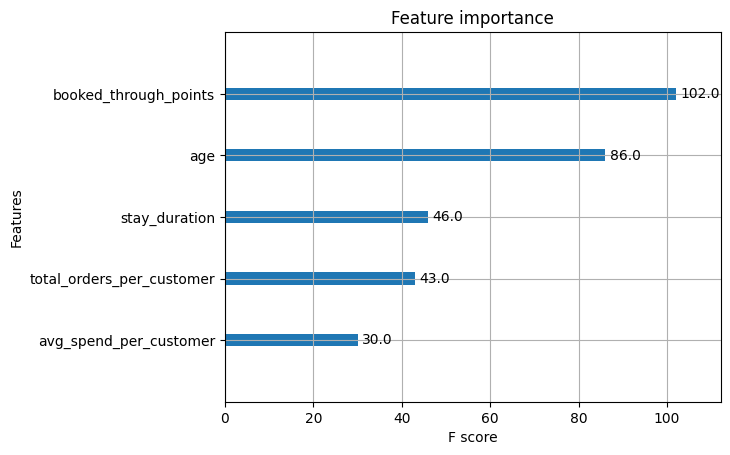

In [50]:
# Feature Importance
xgb.plot_importance(xgb_model, max_num_features=5)
plt.show()